# Importation des packages et du dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
import re # Plus précisement on va utiliser la fonction sub pour remplacer certaines occurences d'un pattern par une 
# par une chaine dans une chaine de caractère
from nltk.corpus import stopwords # pour supprimer les stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Algorithme utilisé
from sklearn.metrics import accuracy_score, classification_report # pour évaluer le modèle
import time # pour la mesure de performance du modèle en terme de temps

train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
train_df.head()
#test_df.head()


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


# Analyse statistique du dataset

In [2]:
# la dimension du dataset 
train_df.shape

(6525, 3)

In [3]:
# On va voir maintenant à quoi ressemble l'individu moyen de notre dataset
train_df.describe()

,TweetId
count,6.525000e+03
mean,2.887131e+17
std,5.139819e+16
min,2.390931e+10
25%,2.941380e+17
50%,3.025319e+17
75%,3.053242e+17
max,3.068341e+17


In [4]:
train_df.describe(include=object)

,Label,TweetText
count,6525,6525
unique,2,6508
top,Sports,'Coaches: Check out the latest content from th...
freq,3325,3


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


## Recherche des valeurs manquantes

In [6]:
train_df.isnull().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

## Representation graphique de chaque catégorie de tweets


/tmp/ipykernel_6850/4123061381.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df,x="Label",palette="bright")


<AxesSubplot:xlabel='Label', ylabel='count'>

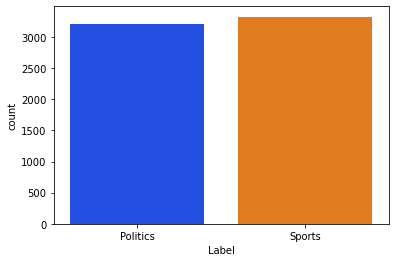

In [7]:
sns.countplot(data=train_df,x="Label",palette="bright")

# Prétraitement des tweets (Natural Processing Language)

In [8]:
train_df.TweetText[:10]

0    '#SecKerry: The value of the @StateDept and @U...
1                              '@rraina1481 I fear so'
2    'Watch video highlights of the #wwc13 final be...
3    'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4    '@cricketfox Always a good thing. Thanks for t...
5    'Dr. Rajan: Fiscal consolidation will create m...
6    FACT: More than 800,000 defense employees will...
7    '1st Test. Over 39: 0 runs, 1 wkt (M Wade 0, M...
8    Some of Africa's top teams will try and take a...
9    'Can you beat the tweet of @RoryGribbell and z...
Name: TweetText, dtype: object

## Supprimer les urls, les mentions(@...), les hastags(#...)
## Convertissons tous les tweests en minuscules pour une meilleur qualité des donnés et aussi la cohérence

In [9]:
#fonction pemettant de supprimer tous ces éléments cités ci-dessus

def clean_process(tweet):
    # Supprimer les mentions d'utilisateurs
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)
    
    # Supprimer les URLs
    tweet = re.sub(r'https?://[A-Za-z0-9./]+', '', tweet)
    
    # Supprimer la ponctuation (sauf les apostrophes utilisées dans les mots)
    tweet = re.sub(r'[^\w\s\']', '', tweet)
    tweet=tweet.lower()#c'est une méthode inplace donc on doit affecter tweet la nouvelle modification
    
    return tweet


In [10]:
tweets=train_df.TweetText
cleaned_tweets=[clean_process(tweet) for tweet in tweets]
print(cleaned_tweets[:20])

["'seckerry the value of the  and  is measured not in dollars but in terms of our deepest american values'", "' i fear so'", "'watch video highlights of the wwc13 final between australia and west indies at '", "'rt  at nitro circus at albertpark  theymakeitlooksoeasy   cantwaitforausgp'", "' always a good thing thanks for the feedback '", "'dr rajan fiscal consolidation will create more space for monetary policies to act'", "fact more than 800000 defense employees will be forced to take unpaid leave if congress doesn't stop impending spending cuts jobsnotcuts", "'1st test over 39 0 runs 1 wkt m wade 0 m clarke 24 aus 1014 indvaus  '", "some of africa's top teams will try and take a step closer to the wt20 this week check out qualifying fixtures ", "'can you beat the tweet of  and zebras stopped play for the most unusual reason for a club cricket match being halted'", "'queensland finished their innings well thanks to a great knock from jason floros 47 qld 9146  ryobiodc'", " thanks won

## Procedons maintenant au traitement des stopwords(les mots vides en terme de sens )

In [11]:
# fonction pour supprimer les stopwords
def remove_stopwords(mots):
    # Récupérer la liste des stopwords en anglais
    stop_words = set(stopwords.words('english'))
    
    # Supprimer les stopwords de la liste des mots
    filtered_words = [word for word in mots if word.lower() not in stop_words]
    
    # Reconstruire le tweet sans les stopwords
    filtered_tweet = ' '.join(filtered_words)
    
    return filtered_tweet


## Phase de  tokenisation 

In [12]:
def tokenize_process(text):
    mots=nltk.word_tokenize(text) 
    return mots

## **On va combiner toutes les fonctions de prétraitements dans une seules fonction pour faciliter le déploiement**

In [13]:
def preproced_tweet(tweet):
    cleaned_tweet=clean_process(tweet)
    mots=tokenize_process(cleaned_tweet)
    tweet_cleaned=remove_stopwords(mots)
   
    return tweet_cleaned

In [24]:
train_df["Cleaned_tweet"]=train_df['TweetText'].apply(preproced_tweet)

In [25]:
train_df.head()

,TweetId,Label,TweetText,Cleaned_tweet
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...,'seckerry value measured dollars terms deepest...
1,304834304222064640,Politics,'@rraina1481 I fear so',' fear '
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...,'watch video highlights wwc13 final australia ...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,'rt nitro circus albertpark theymakeitlooksoea...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...,' always good thing thanks feedback '


## Representation des données

### Extraction des varaibles explicatives et expliquées

In [16]:
# L'id d'un tweet ne porte aucune information donc on va l'ignorer pour le modèle

X=train_df['Cleaned_tweet']
y=train_df['Label']

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape

(5220,)

## Extraction feature

In [26]:

# Vectorize the text using TF-IDF
vect = TfidfVectorizer(max_features=5000)
X_train_tfidf=vect.fit_transform(X_train)
X_val_tfidf=vect.transform(X_val)


# Phase de construction de modèle

## Je vais utiliser l'algorithme SVM(Support Vector Modèle) Pour la construction du modèle

In [27]:

clf =SVC(C=1,kernel='linear', random_state=42,gamma='auto')
clf.fit(X_train_tfidf, y_train)
predictions=clf.predict(X_val_tfidf)

svm_accuracy=accuracy_score(y_val,predictions)
svm_report=classification_report(y_val,predictions)
print("Accuracy:" ,svm_accuracy)
print(svm_report)


Accuracy: 0.9340996168582375
              precision    recall  f1-score   support

    Politics       0.94      0.93      0.93       638
      Sports       0.93      0.94      0.94       667

    accuracy                           0.93      1305
   macro avg       0.93      0.93      0.93      1305
weighted avg       0.93      0.93      0.93      1305



## Pour le modele turning on peut varier la valeur de kernel pour voir la forme de hyperplan qui correspond au mieux et la valeur de C Ici la combinaison des valeurs approprié c'est kernel='linear' et C=1 par defaut

# Test

In [19]:
test_df.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


In [20]:
test_df["Cleaned_tweet"]=test_df['TweetText'].apply(preproced_tweet)

In [21]:
X_test_tfidf=vect.transform(test_df['Cleaned_tweet'])
submissions=clf.predict(X_test_tfidf)

print(submissions)
test_df['Label']=submissions
test_df.head()

['Sports' 'Sports' 'Politics' ... 'Sports' 'Politics' 'Sports']


,TweetId,TweetText,Cleaned_tweet,Label
0,306486520121012224,'28. The home side threaten again through Maso...,'28 home side threaten mason bennett gets end ...,Sports
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....,' thx asking see derives series abbreviations ...,Sports
2,289531046037438464,'@Sochi2014 construction along the shores of t...,' construction along shores black sea ',Politics
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...,'seckerryu2019s remarks meeting foreign minist...,Politics
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...,'the iplauction begun ricky ponting first play...,Sports


## Model performance

In [28]:
#temps de prétraitement

start_preproced_time=time.time()
train_df["Cleaned_tweet"]=train_df['TweetText'].apply(preproced_tweet)
vect = TfidfVectorizer(max_features=5220)
X_train_tfidf=vect.fit_transform(X_train)
X_val_tfidf=vect.transform(X_val)

end_preproced_time=time.time()
pre_time=end_preproced_time-start_preproced_time

#temps d'entrainement

start_train_time=time.time()

clf =SVC(C=1,kernel='linear', random_state=42,gamma='auto')
clf.fit(X_train_tfidf, y_train)

end_train_time=time.time()

train_time=end_train_time-start_train_time

#temps de prédiction

start_test_time=time.time()

predictions=clf.predict(X_val_tfidf)

end_test_time=time.time()

test_time=end_test_time-start_test_time
#accuracy 
svm_accuracy=accuracy_score(y_val,predictions)
svm_report=classification_report(y_val,predictions)

print("Accuracy:" ,svm_accuracy)
print("Temps de prétraitement:" ,pre_time)
print(" Temps d'entrainement:" ,train_time)
print("Tems de prédiction:" ,test_time)
print(svm_report)


Accuracy: 0.9348659003831418
Temps de prétraitement: 2.6816458702087402
 Temps d'entrainement: 1.7254109382629395
Tems de prédiction: 0.29900431632995605
              precision    recall  f1-score   support

    Politics       0.94      0.93      0.93       638
      Sports       0.93      0.94      0.94       667

    accuracy                           0.93      1305
   macro avg       0.93      0.93      0.93      1305
weighted avg       0.93      0.93      0.93      1305



In [30]:
sub=test_df[['TweetId','Label']]
sub.head()

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports


In [33]:
sub.to_csv("submissions.csv",index=False)